In [1]:
import os
# Make TensorFlow logs less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from collections import OrderedDict
from typing import List, Tuple, Dict

import flwr as fl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from flwr.common import Metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from numpy.typing import ArrayLike, NDArray
import tensorflow as tf
from models_supervised import build_ANN, build_decision_tree, build_random_forest, build_knn, build_svm, build_NB
from evaluate import eval_model,plot_cm


# Make keras available in this namespace (for IntelliSense)
keras = tf.keras

SEED = 1138

tf.keras.utils.set_random_seed(SEED)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism()

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from typing import Tuple
from dataset.data import Dataset
from dataset.nfv2 import load_data

cicids: Tuple[Dataset, Dataset] = load_data("data/sampled/cicids_sampled.csv.gz", seed=SEED, n_partition=1, only_benign=False)
botiot: Tuple[Dataset, Dataset] = load_data("data/sampled/botiot_sampled.csv.gz", seed=SEED, n_partition=1, only_benign=False) 
nb15: Tuple[Dataset, Dataset] = load_data("data/sampled/nb15_sampled.csv.gz", seed=SEED, n_partition=1, only_benign=False) 
toniot: Tuple[Dataset, Dataset] = load_data("data/sampled/toniot_sampled.csv.gz", seed=SEED, n_partition=1, only_benign=False) 

cicids_train, cicids_test = cicids
botiot_train, botiot_test = botiot
nb15_train, nb15_test = nb15
toniot_train, toniot_test = toniot

Baseline Benchmarks of ANN

In [3]:
bl_model = build_ANN(cicids_train.X)
bl_model.fit(cicids_train.to_sequence(batch_size=512, target=1),epochs=10)
bl_metrics = eval_model(bl_model,cicids_test.X,cicids_test.y)[1]
bl_acc = bl_metrics["accuracy"]
bl_prec = bl_metrics["precision"]
bl_rec = bl_metrics["recall"]
bl_f1 = bl_metrics["f1"]
bl_miss = bl_metrics["miss_rate"]
bl_weights = bl_model.get_weights()

print(f"Baseline Accuracy: {bl_acc:.4f}")
print(f"Baseline Precision: {bl_prec:.4f}")
print(f"Baseline Recall: {bl_rec:.4f}")
print(f"Baseline F1: {bl_f1:.4f}")
print(f"Baseline Miss Rate: {bl_miss:.4f}")


Epoch 1/10
1563/1563 [==============================] - 8s 4ms/step - loss: 0.1718 - accuracy: 0.9542
Epoch 2/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0783 - accuracy: 0.9787
Epoch 3/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0625 - accuracy: 0.9860
Epoch 4/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0541 - accuracy: 0.9875
Epoch 5/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0491 - accuracy: 0.9886
Epoch 6/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0459 - accuracy: 0.9895
Epoch 7/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0437 - accuracy: 0.9898
Epoch 8/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.0419 - accuracy: 0.9902
Epoch 9/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0402 - accuracy: 0.9909
Epoch 10/10
6250/6250 [==============================] - 7s 1ms/step
Baseline Accu

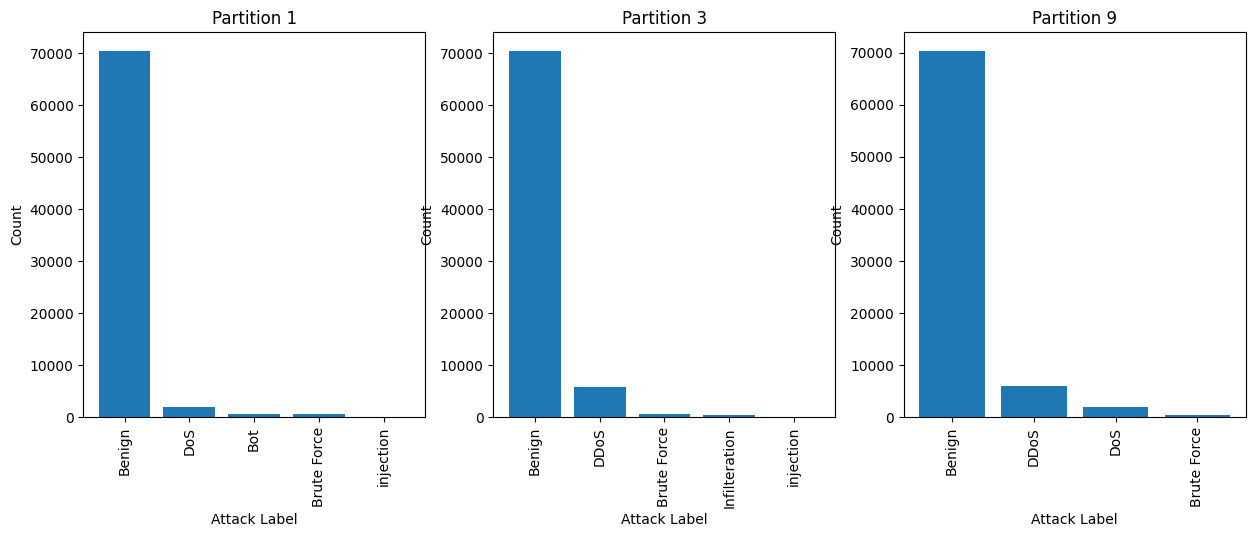

In [4]:
from partitions import partition_1
#use on default settings of NUM_CLIENTS = 10
partitions = partition_1(cicids_train,2)

Epoch 1/10


144/144 [==============================] - 1s 4ms/step - loss: 0.4877 - accuracy: 0.9281
Epoch 2/10
144/144 [==============================] - 1s 4ms/step - loss: 0.2206 - accuracy: 0.9570
Epoch 3/10
144/144 [==============================] - 1s 4ms/step - loss: 0.1349 - accuracy: 0.9570
Epoch 4/10
144/144 [==============================] - 1s 4ms/step - loss: 0.0979 - accuracy: 0.9714
Epoch 5/10
144/144 [==============================] - 1s 4ms/step - loss: 0.0797 - accuracy: 0.9845
Epoch 6/10
144/144 [==============================] - 1s 4ms/step - loss: 0.0685 - accuracy: 0.9848
Epoch 7/10
144/144 [==============================] - 1s 4ms/step - loss: 0.0600 - accuracy: 0.9841
Epoch 8/10
144/144 [==============================] - 1s 4ms/step - loss: 0.0529 - accuracy: 0.9841
Epoch 9/10
144/144 [==============================] - 1s 4ms/step - loss: 0.0466 - accuracy: 0.9840
Epoch 10/10
6250/6250 [==============================] - 6s 1ms/step
Epoch 1/10
155/155 [======================

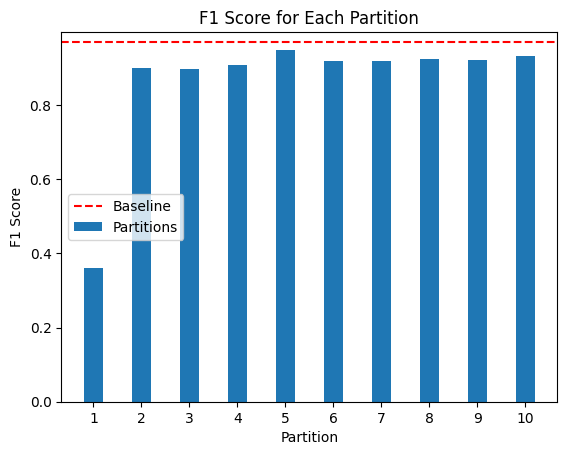

In [6]:
'''model = build_ANN(cicids_train.X)
LOCAL_WEIGHTS = []

part = partitions[1]

hist = model.fit(part[0], part[1], batch_size=512,epochs=10)

LOCAL_WEIGHTS = model.get_weights()

cm, metrics, loss = eval_model(model, cicids_test.X, cicids_test.y)
plot_cm(cm)

# print model metrics against the baseline
print(f"Accuracy: {metrics['accuracy']:.4f} (Baseline: {bl_acc:.4f}, % Diff: {100 * (metrics['accuracy'] - bl_acc) / bl_acc:.2f})")
print(f"Precision: {metrics['precision']:.4f} (Baseline: {bl_prec:.4f}, % Diff: {100 * (metrics['precision'] - bl_prec) / bl_prec:.2f})")
print(f"Recall: {metrics['recall']:.4f} (Baseline: {bl_rec:.4f}, % Diff: {100 * (metrics['recall'] - bl_rec) / bl_rec:.2f})")
print(f"F1: {metrics['f1']:.4f} (Baseline: {bl_f1:.4f}, % Diff: {100 * (metrics['f1'] - bl_f1) / bl_f1:.2f})")
print(f"Miss Rate: {metrics['miss_rate']:.4f} (Baseline: {bl_miss:.4f}, % Diff: {100 * (metrics['miss_rate'] - bl_miss) / bl_miss:.2f})")'''
model = build_ANN(cicids_train.X)
LOCAL_WEIGHTS = []

f1_scores = []

for part in partitions:
    hist = model.fit(part[0], part[1], batch_size=512, epochs=10)
    
    weights = model.get_weights()
    LOCAL_WEIGHTS.append(weights)
    
    _, metrics, _ = eval_model(model, cicids_test.X, cicids_test.y)
    f1_scores.append(metrics['f1'])

# Plot F1 scores for each partition and baseline
partition_numbers = range(1,len(partitions)+1)
width = 0.4
plt.bar(partition_numbers, f1_scores, width, label='Partitions')
plt.axhline(y=bl_f1, color='r', linestyle='--', label='Baseline')
plt.xlabel('Partition')
plt.ylabel('F1 Score')
plt.title('F1 Score for Each Partition')
plt.xticks(partition_numbers)
plt.legend()
plt.show()


In [8]:
m_test = cicids_train[2]["Attack"]
inferences = model.predict(cicids_test.X)

y_pred = np.round(inferences)

# remember: part[3] contains a list of the removed classes
y_pred_lack = y_pred[m_test.isin(part[3])]

print(f"Percentage of removed attacks detected (Local): {100 * len(y_pred_lack[y_pred_lack == 1]) / len(y_pred_lack):.2f}%")

# try with the baseline model
model.set_weights(bl_weights)

inferences = model.predict(cicids_test.X)

y_pred = np.round(inferences)
y_pred_lack = y_pred[m_test.isin(part[3])]
print(f"Percentage of removed attacks detected (Baseline): {100 * len(y_pred_lack[y_pred_lack == 1]) / len(y_pred_lack):.2f}%")

6250/6250 [==============================] - 6s 999us/step
Percentage of removed attacks detected (Local): 3.27%
6250/6250 [==============================] - 6s 1ms/step
Percentage of removed attacks detected (Baseline): 2.04%


Federated Learning

In [9]:
import logging

class FlwrClient(fl.client.NumPyClient):
    def __init__(self, cid, X, y):
        self.X_train = X
        self.y_train = y
        self.cid = cid
        self.model = build_ANN(cicids_train.X)
        self.logger = logging.getLogger(__name__)
        self.logger.warning("Initialized client")

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(
            self.X_train,
            self.y_train,
            epochs=config["epochs"],
            batch_size=config["batch_size"],
            verbose=0,
        )
        return self.model.get_weights(), len(self.X_train), {}


In [10]:
CIDS = [ f"client_{i}" for i in range(NUM_CLIENTS) ]

cids_parts = dict(zip(CIDS, partitions))

def client_fn(cid: str) -> fl.client.NumPyClient:
    return FlwrClient(
        cid,
        cids_parts[cid][0],
        cids_parts[cid][1],
    )

In [11]:
from typing import Optional
from flwr.common import Scalar, NDArrays, ndarrays_to_parameters

FL_WEIGHTS = None
init_params = ndarrays_to_parameters(build_ANN(cicids_train.X).get_weights())
    
# The `evaluate` function will be called after every round
def evaluate_fn(
    server_round: int, parameters: NDArrays, config: Dict[str, Scalar]
) -> Optional[Tuple[float, Dict[str, Scalar]]]:
    if server_round == 10:
        global FL_WEIGHTS
        FL_WEIGHTS = parameters

    model = build_ANN(cicids_train.X)

    model.set_weights(parameters)  # Update model with the latest parameters
    _, metrics, loss = eval_model(model, cicids_test.X, cicids_test.y)
    return loss, metrics

strat = fl.server.strategy.FedAvg(
    fraction_fit=1.0,           # Sample 100% of available clients for training
    min_fit_clients=10,         # Never sample less than 10 clients for training
    min_available_clients=10,   # Wait until all 10 clients are available
    accept_failures = False,
    evaluate_fn=evaluate_fn,    # Evaluate the model after each round using this function
    on_fit_config_fn=lambda rnd: {  # Use this function to configure the training
        "epochs": 10,                # Train for 1 epoch 
        "batch_size": 32,           # Use a batch size of 32
    },
    initial_parameters=init_params,    # Initialize the model with these parameters
)

Federating

In [12]:
print(f"Number of clients: {NUM_CLIENTS}")
for k, v in cids_parts.items():
    print(f"  {k}: \t X: {v[0].shape}, lacks: {v[3]}")

Number of clients: 10
  client_0: 	 X: (73572, 39), lacks: ['Bot' 'DDoS']
  client_1: 	 X: (79506, 39), lacks: ['injection' 'Infilteration']
  client_2: 	 X: (77471, 39), lacks: ['Infilteration' 'DoS']
  client_3: 	 X: (78936, 39), lacks: ['Bot' 'Infilteration']
  client_4: 	 X: (78938, 39), lacks: ['Bot' 'Brute Force']
  client_5: 	 X: (78896, 39), lacks: ['Infilteration' 'Bot']
  client_6: 	 X: (77522, 39), lacks: ['Infilteration' 'DoS']
  client_7: 	 X: (79499, 39), lacks: ['injection' 'Infilteration']
  client_8: 	 X: (78903, 39), lacks: ['Infilteration' 'Bot']
  client_9: 	 X: (78934, 39), lacks: ['Bot' 'Infilteration']


In [13]:
hist = fl.simulation.start_simulation(
    client_fn=client_fn,
    clients_ids=CIDS,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strat,
)

INFO flwr 2023-07-12 17:28:17,759 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-07-12 17:28:20,054	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-07-12 17:28:21,033 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 192.0, 'object_store_memory': 200000000000.0, 'memory': 587500936192.0, 'GPU': 1.0, 'node:10.42.0.174': 1.0}
INFO flwr 2023-07-12 17:28:21,034 | server.py:86 | Initializing global parameters
INFO flwr 2023-07-12 17:28:21,034 | server.py:269 | Using initial parameters provided by strategy
INFO flwr 2023-07-12 17:28:21,034 | server.py:88 | Evaluating initial parameters


6250/6250 [==============================] - 7s 1ms/step


INFO flwr 2023-07-12 17:28:38,757 | server.py:91 | initial parameters (loss, other metrics): 0.7029194235801697, {'accuracy': 0.194175, 'precision': 0.12088476513959076, 'recall': 0.9167364717708159, 'f1': 0.213602939382554, 'miss_rate': 0.08326352822918412}
INFO flwr 2023-07-12 17:28:38,758 | server.py:101 | FL starting
DEBUG flwr 2023-07-12 17:28:38,759 | server.py:218 | fit_round 1: strategy sampled 10 clients (out of 10)
(launch_and_fit pid=586519) Initialized client
DEBUG flwr 2023-07-12 17:29:23,608 | server.py:232 | fit_round 1 received 10 results and 0 failures
WARNING flwr 2023-07-12 17:29:23,629 | fedavg.py:243 | No fit_metrics_aggregation_fn provided


6250/6250 [==============================] - 7s 1ms/step


INFO flwr 2023-07-12 17:29:42,135 | server.py:119 | fit progress: (1, 0.24560891091823578, {'accuracy': 0.97568, 'precision': 0.9862404092071612, 'recall': 0.8075473278606131, 'f1': 0.8879933680283701, 'miss_rate': 0.19245267213938683}, 63.376068100998964)
DEBUG flwr 2023-07-12 17:29:42,136 | server.py:168 | evaluate_round 1: strategy sampled 10 clients (out of 10)
(launch_and_evaluate pid=586555) Initialized client [repeated 10x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
DEBUG flwr 2023-07-12 17:29:48,019 | server.py:182 | evaluate_round 1 received 0 results and 10 failures
DEBUG flwr 2023-07-12 17:29:48,021 | server.py:218 | fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-07-12 17:30:28,590 | server.py:232 | fit_round 2 received 10 results and 0 failures


6250/6250 [==============================] - 7s 1ms/step


INFO flwr 2023-07-12 17:30:46,623 | server.py:119 | fit progress: (2, 0.36457860469818115, {'accuracy': 0.98184, 'precision': 0.9827816464752457, 'recall': 0.8630005025967499, 'f1': 0.9190045047054101, 'miss_rate': 0.13699949740325013}, 127.86396680899998)
DEBUG flwr 2023-07-12 17:30:46,624 | server.py:168 | evaluate_round 2: strategy sampled 10 clients (out of 10)
(launch_and_evaluate pid=586522) Initialized client [repeated 20x across cluster]
DEBUG flwr 2023-07-12 17:30:50,742 | server.py:182 | evaluate_round 2 received 0 results and 10 failures
DEBUG flwr 2023-07-12 17:30:50,743 | server.py:218 | fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-07-12 17:31:31,689 | server.py:232 | fit_round 3 received 10 results and 0 failures


6250/6250 [==============================] - 7s 1ms/step


INFO flwr 2023-07-12 17:31:49,564 | server.py:119 | fit progress: (3, 0.4806155562400818, {'accuracy': 0.98344, 'precision': 0.9802877428998505, 'recall': 0.8789579494052605, 'f1': 0.9268615846656656, 'miss_rate': 0.12104205059473949}, 190.80549293900185)
DEBUG flwr 2023-07-12 17:31:49,566 | server.py:168 | evaluate_round 3: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-07-12 17:31:54,089 | server.py:182 | evaluate_round 3 received 0 results and 10 failures
DEBUG flwr 2023-07-12 17:31:54,091 | server.py:218 | fit_round 4: strategy sampled 10 clients (out of 10)
(launch_and_evaluate pid=586555) Initialized client [repeated 20x across cluster]
DEBUG flwr 2023-07-12 17:32:36,164 | server.py:232 | fit_round 4 received 10 results and 0 failures


6250/6250 [==============================] - 7s 1ms/step


INFO flwr 2023-07-12 17:32:54,064 | server.py:119 | fit progress: (4, 0.5730526447296143, {'accuracy': 0.9835, 'precision': 0.980792597439013, 'recall': 0.87899983246775, 'f1': 0.9271104828378318, 'miss_rate': 0.12100016753224996}, 255.30496687100094)
DEBUG flwr 2023-07-12 17:32:54,065 | server.py:168 | evaluate_round 4: strategy sampled 10 clients (out of 10)
(launch_and_evaluate pid=586555) Initialized client [repeated 20x across cluster]
DEBUG flwr 2023-07-12 17:32:58,433 | server.py:182 | evaluate_round 4 received 0 results and 10 failures
DEBUG flwr 2023-07-12 17:32:58,434 | server.py:218 | fit_round 5: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-07-12 17:33:39,990 | server.py:232 | fit_round 5 received 10 results and 0 failures


6250/6250 [==============================] - 6s 1ms/step


INFO flwr 2023-07-12 17:33:57,796 | server.py:119 | fit progress: (5, 0.6279676556587219, {'accuracy': 0.97916, 'precision': 0.9411712034383954, 'recall': 0.8804657396548836, 'f1': 0.9098069765428893, 'miss_rate': 0.11953426034511644}, 319.03722855999877)
DEBUG flwr 2023-07-12 17:33:57,797 | server.py:168 | evaluate_round 5: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-07-12 17:34:01,942 | server.py:182 | evaluate_round 5 received 0 results and 10 failures
DEBUG flwr 2023-07-12 17:34:01,943 | server.py:218 | fit_round 6: strategy sampled 10 clients (out of 10)
(launch_and_evaluate pid=586555) Initialized client [repeated 20x across cluster]
DEBUG flwr 2023-07-12 17:34:42,089 | server.py:232 | fit_round 6 received 10 results and 0 failures


6250/6250 [==============================] - 7s 1ms/step


INFO flwr 2023-07-12 17:34:59,940 | server.py:119 | fit progress: (6, 0.6385029554367065, {'accuracy': 0.98311, 'precision': 0.9759450171821306, 'recall': 0.8802144412799464, 'f1': 0.9256110988768994, 'miss_rate': 0.11978555872005361}, 381.18113952000203)
DEBUG flwr 2023-07-12 17:34:59,941 | server.py:168 | evaluate_round 6: strategy sampled 10 clients (out of 10)
(launch_and_evaluate pid=586555) Initialized client [repeated 20x across cluster]
DEBUG flwr 2023-07-12 17:35:04,124 | server.py:182 | evaluate_round 6 received 0 results and 10 failures
DEBUG flwr 2023-07-12 17:35:04,126 | server.py:218 | fit_round 7: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-07-12 17:35:44,267 | server.py:232 | fit_round 7 received 10 results and 0 failures


6250/6250 [==============================] - 7s 1ms/step


INFO flwr 2023-07-12 17:36:02,419 | server.py:119 | fit progress: (7, 0.6139155030250549, {'accuracy': 0.98485, 'precision': 0.9874660929753999, 'recall': 0.8843189814039203, 'f1': 0.9330505104069998, 'miss_rate': 0.11568101859607975}, 443.66020523000043)
DEBUG flwr 2023-07-12 17:36:02,421 | server.py:168 | evaluate_round 7: strategy sampled 10 clients (out of 10)
(launch_and_evaluate pid=586522) Initialized client [repeated 20x across cluster]
DEBUG flwr 2023-07-12 17:36:06,728 | server.py:182 | evaluate_round 7 received 0 results and 10 failures
DEBUG flwr 2023-07-12 17:36:06,729 | server.py:218 | fit_round 8: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-07-12 17:36:46,250 | server.py:232 | fit_round 8 received 10 results and 0 failures


6250/6250 [==============================] - 7s 1ms/step


INFO flwr 2023-07-12 17:37:04,196 | server.py:119 | fit progress: (8, 0.5645247101783752, {'accuracy': 0.98626, 'precision': 0.9917605437110139, 'recall': 0.8923186463394204, 'f1': 0.9394153181357203, 'miss_rate': 0.10768135366057967}, 505.4369689129999)
DEBUG flwr 2023-07-12 17:37:04,197 | server.py:168 | evaluate_round 8: strategy sampled 10 clients (out of 10)
(launch_and_evaluate pid=586555) Initialized client [repeated 20x across cluster]
DEBUG flwr 2023-07-12 17:37:08,400 | server.py:182 | evaluate_round 8 received 0 results and 10 failures
DEBUG flwr 2023-07-12 17:37:08,402 | server.py:218 | fit_round 9: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-07-12 17:37:48,428 | server.py:232 | fit_round 9 received 10 results and 0 failures


6250/6250 [==============================] - 7s 1ms/step


INFO flwr 2023-07-12 17:38:06,330 | server.py:119 | fit progress: (9, 0.5109939575195312, {'accuracy': 0.99359, 'precision': 0.9940090956795522, 'recall': 0.952043893449489, 'f1': 0.9725740201951053, 'miss_rate': 0.047956106550510975}, 567.5711773610019)
DEBUG flwr 2023-07-12 17:38:06,332 | server.py:168 | evaluate_round 9: strategy sampled 10 clients (out of 10)
(launch_and_evaluate pid=586522) Initialized client [repeated 20x across cluster]
DEBUG flwr 2023-07-12 17:38:10,699 | server.py:182 | evaluate_round 9 received 0 results and 10 failures
DEBUG flwr 2023-07-12 17:38:10,700 | server.py:218 | fit_round 10: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-07-12 17:38:50,894 | server.py:232 | fit_round 10 received 10 results and 0 failures


6250/6250 [==============================] - 7s 1ms/step


INFO flwr 2023-07-12 17:39:09,119 | server.py:119 | fit progress: (10, 0.48014503717422485, {'accuracy': 0.99371, 'precision': 0.9960958062818038, 'recall': 0.9510386999497403, 'f1': 0.9730459376071307, 'miss_rate': 0.04896130005025968}, 630.3605364649993)
DEBUG flwr 2023-07-12 17:39:09,121 | server.py:168 | evaluate_round 10: strategy sampled 10 clients (out of 10)
(launch_and_evaluate pid=586555) Initialized client [repeated 20x across cluster]
DEBUG flwr 2023-07-12 17:39:13,465 | server.py:182 | evaluate_round 10 received 0 results and 10 failures
INFO flwr 2023-07-12 17:39:13,466 | server.py:147 | FL finished in 634.7068701489989
INFO flwr 2023-07-12 17:39:13,483 | app.py:218 | app_fit: losses_distributed []
INFO flwr 2023-07-12 17:39:13,484 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO flwr 2023-07-12 17:39:13,485 | app.py:220 | app_fit: metrics_distributed {}
INFO flwr 2023-07-12 17:39:13,485 | app.py:221 | app_fit: losses_centralized [(0, 0.7029194235801697), (1, 0.245

In [14]:
# try with the baseline model
model.set_weights(LOCAL_WEIGHTS)

inferences = model.predict(cicids_test.X)

y_pred = np.round(inferences)
y_pred_lack = y_pred[m_test.isin(part[3])]
print(f"Percentage of removed attacks detected (Local): {100 * len(y_pred_lack[y_pred_lack == 1]) / len(y_pred_lack):.2f}%")

model.set_weights(FL_WEIGHTS)

inferences = model.predict(cicids_test.X)

y_pred = np.round(inferences)

# remember: part[3] contains a list of the removed classes
y_pred_lack = y_pred[m_test.isin(part[3])]

print(f"Percentage of removed attacks detected (FL): {100 * len(y_pred_lack[y_pred_lack == 1]) / len(y_pred_lack):.2f}%")

# try with the baseline model
model.set_weights(bl_weights)

inferences = model.predict(cicids_test.X)

y_pred = np.round(inferences)
y_pred_lack = y_pred[m_test.isin(part[3])]
print(f"Percentage of removed attacks detected (Baseline): {100 * len(y_pred_lack[y_pred_lack == 1]) / len(y_pred_lack):.2f}%")

6250/6250 [==============================] - 7s 1ms/step
Percentage of removed attacks detected (Local): 3.27%
6250/6250 [==============================] - 7s 1ms/step
Percentage of removed attacks detected (FL): 16.82%
6250/6250 [==============================] - 7s 1ms/step
Percentage of removed attacks detected (Baseline): 2.04%


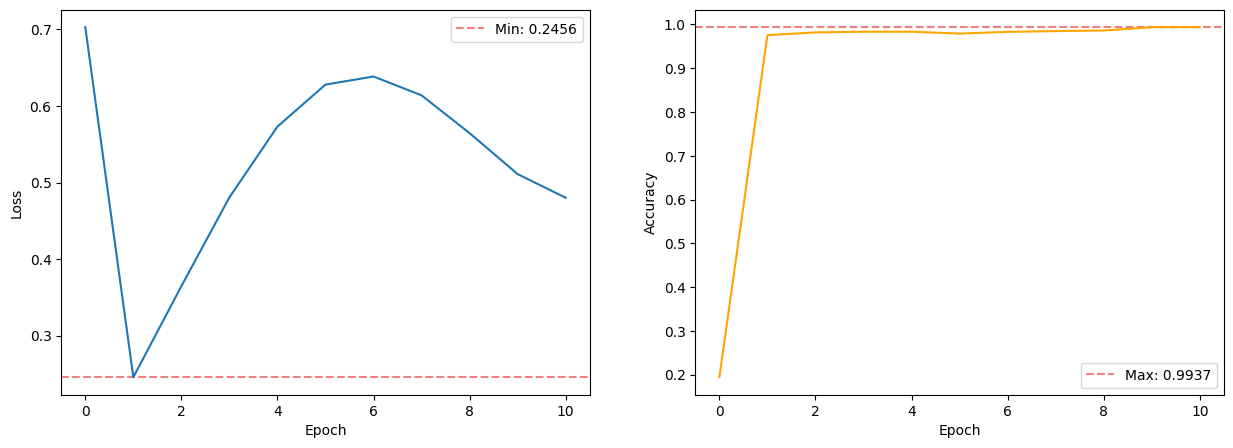

In [15]:
loss = [i[1] for i in hist.losses_centralized]
acc = [i[1] for i in hist.metrics_centralized["accuracy"]]

# plot training history, loss and accuracy side by side
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
_min = np.min(loss)
ax1.axhline(y=_min, label=f"Min: {_min:.4f}", linestyle='--', color='lightcoral')
ax1.plot(loss)
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend()
_max = np.max(acc)
ax2.axhline(y=_max, label=f"Max: {_max:.4f}", linestyle='--', color='lightcoral')
ax2.plot(acc, color='orange')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend()
plt.show()

Decision Trees

In [16]:
from sklearn import tree
def build_decision_tree():

    model = tree.DecisionTreeClassifier(criterion="log_loss")

    return model


In [17]:
def eval_model_others(model: keras.Model, X, y) :
    """Evaluate the model on the given data and return the confusion matrix and metrics"""

    inferences = model.predict(X)
    y_pred = np.round(inferences).astype(int)
    y_true = y.to_numpy()

    cm = confusion_matrix(y_true, y_pred)

    if cm.shape != (2, 2):
        raise ValueError("Confusion matrix has an unexpected shape.")

    tn, fp, fn, tp = cm.ravel()

    return cm,{
        'accuracy': (tn + tp) / (tn + fp + fn + tp),
        'precision': tp / (tp + fp),
        'recall': tp / (tp + fn),
        'f1': 2 * tp / (2 * tp + fp + fn),
        'miss_rate': fn / (fn + tp)
    }


In [18]:
bl_model = build_decision_tree()
bl_model.fit(cicids_train.X,cicids_train.y)
bl_metrics = eval_model_others(bl_model,cicids_test.X,cicids_test.y)[1]
bl_acc = bl_metrics["accuracy"]
bl_prec = bl_metrics["precision"]
bl_rec = bl_metrics["recall"]
bl_f1 = bl_metrics["f1"]
bl_miss = bl_metrics["miss_rate"]
bl_params = bl_model.get_params()
print(bl_params)

print(f"Baseline Accuracy: {bl_acc:.4f}")
print(f"Baseline Precision: {bl_prec:.4f}")
print(f"Baseline Recall: {bl_rec:.4f}")
print(f"Baseline F1: {bl_f1:.4f}")
print(f"Baseline Miss Rate: {bl_miss:.4f}")

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
Baseline Accuracy: 0.9917
Baseline Precision: 0.9636
Baseline Recall: 0.9667
Baseline F1: 0.9651
Baseline Miss Rate: 0.0333


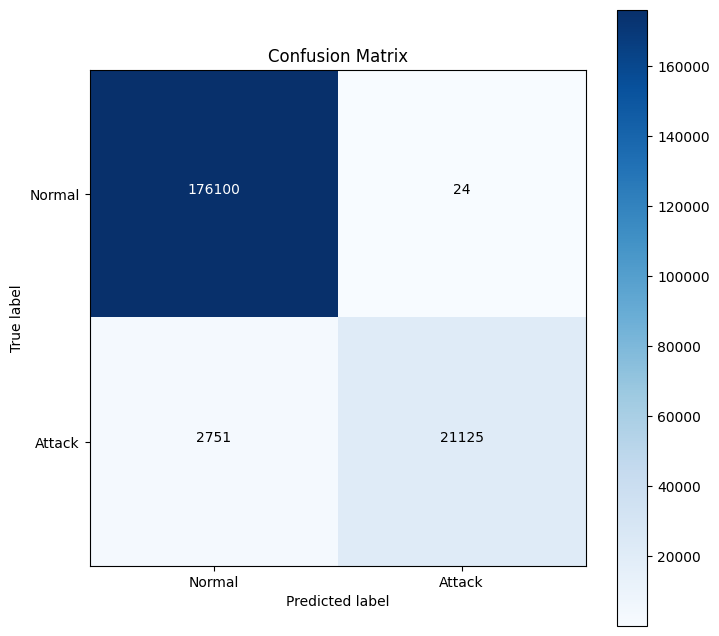

Accuracy: 0.9861 (Baseline: 0.9917, % Diff: -0.56)
Precision: 0.9989 (Baseline: 0.9636, % Diff: 3.66)
Recall: 0.8848 (Baseline: 0.9667, % Diff: -8.47)
F1: 0.9384 (Baseline: 0.9651, % Diff: -2.77)
Miss Rate: 0.1152 (Baseline: 0.0333, % Diff: 245.60)


In [19]:
model = build_decision_tree()

part = partitions[8]

hist = model.fit(part[0], part[1])

LOCAL_PARAMS = model.get_params()

cm, metrics = eval_model_others(model, cicids_test.X, cicids_test.y)
plot_cm(cm)

# print model metrics against the baseline
print(f"Accuracy: {metrics['accuracy']:.4f} (Baseline: {bl_acc:.4f}, % Diff: {100 * (metrics['accuracy'] - bl_acc) / bl_acc:.2f})")
print(f"Precision: {metrics['precision']:.4f} (Baseline: {bl_prec:.4f}, % Diff: {100 * (metrics['precision'] - bl_prec) / bl_prec:.2f})")
print(f"Recall: {metrics['recall']:.4f} (Baseline: {bl_rec:.4f}, % Diff: {100 * (metrics['recall'] - bl_rec) / bl_rec:.2f})")
print(f"F1: {metrics['f1']:.4f} (Baseline: {bl_f1:.4f}, % Diff: {100 * (metrics['f1'] - bl_f1) / bl_f1:.2f})")
print(f"Miss Rate: {metrics['miss_rate']:.4f} (Baseline: {bl_miss:.4f}, % Diff: {100 * (metrics['miss_rate'] - bl_miss) / bl_miss:.2f})")


In [20]:
inferences = model.predict(cicids_test.X)

y_pred = np.round(inferences)

# remember: part[3] contains a list of the removed classes
y_pred_lack = y_pred[m_test.isin(part[3])]

print(f"Percentage of removed attacks detected (Local): {100 * len(y_pred_lack[y_pred_lack == 1]) / len(y_pred_lack):.2f}%")
print(model.get_params())
# try with the baseline model
model = build_decision_tree()
model.fit(part[0], part[1])
model.set_params(**bl_params)
print(model.get_params())

inferences = model.predict(cicids_test.X)

y_pred = np.round(inferences)
y_pred_lack = y_pred[m_test.isin(part[3])]
print(f"Percentage of removed attacks detected (Baseline): {100 * len(y_pred_lack[y_pred_lack == 1]) / len(y_pred_lack):.2f}%")

Percentage of removed attacks detected (Local): 0.00%
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
Percentage of removed attacks detected (Baseline): 0.00%


Naive Bayes

In [27]:
bl_model = build_NB()
bl_model.fit(cicids_train.X,cicids_train.y)
bl_metrics = eval_model_others(bl_model,cicids_test.X,cicids_test.y)[1]
bl_acc = bl_metrics["accuracy"]
bl_prec = bl_metrics["precision"]
bl_rec = bl_metrics["recall"]
bl_f1 = bl_metrics["f1"]
bl_miss = bl_metrics["miss_rate"]
bl_params = [bl_model.class_count_,bl_model.class_prior_,bl_model.theta_]
print(bl_params)

print(f"Baseline Accuracy: {bl_acc:.4f}")
print(f"Baseline Precision: {bl_prec:.4f}")
print(f"Baseline Recall: {bl_rec:.4f}")
print(f"Baseline F1: {bl_f1:.4f}")
print(f"Baseline Miss Rate: {bl_miss:.4f}")

[array([704499.,  95501.]), array([0.88062375, 0.11937625]), array([[1.77388819e-01, 4.66692540e-02, 4.86824795e-05, 3.16128254e-05,
        4.46362586e-05, 8.13935263e-05, 2.93703969e-01, 2.90571851e-01,
        9.26034853e-02, 3.97696258e-02, 1.81012174e-05, 7.22879594e-05,
        2.62908223e-01, 2.63380259e-01, 7.57485410e-03, 1.82739357e-02,
        3.98917438e-02, 7.57485410e-03, 3.67708930e-93, 1.41948487e-06,
        5.04610263e-04, 1.61820001e-03, 3.73797674e-05, 1.18162754e-04,
        1.48471235e-03, 3.58636572e-03, 4.93076334e-05, 7.55414907e-04,
        5.96122114e-04, 2.24900362e-04, 4.24828559e-05, 1.15924893e-01,
        3.11281283e-01, 5.04530082e-02, 5.04529919e-02, 2.30074524e-01,
        1.72438659e-02, 3.59454118e-02, 0.00000000e+00],
       [9.51723294e-02, 7.52242409e-02, 4.99536503e-04, 6.33654380e-04,
        1.10194123e-05, 7.44048515e-05, 6.99896317e-01, 6.96556930e-01,
        1.15771145e-01, 8.26662116e-01, 1.65812713e-03, 5.76100717e-03,
        4.11580538

{'priors': None, 'var_smoothing': 1e-09}


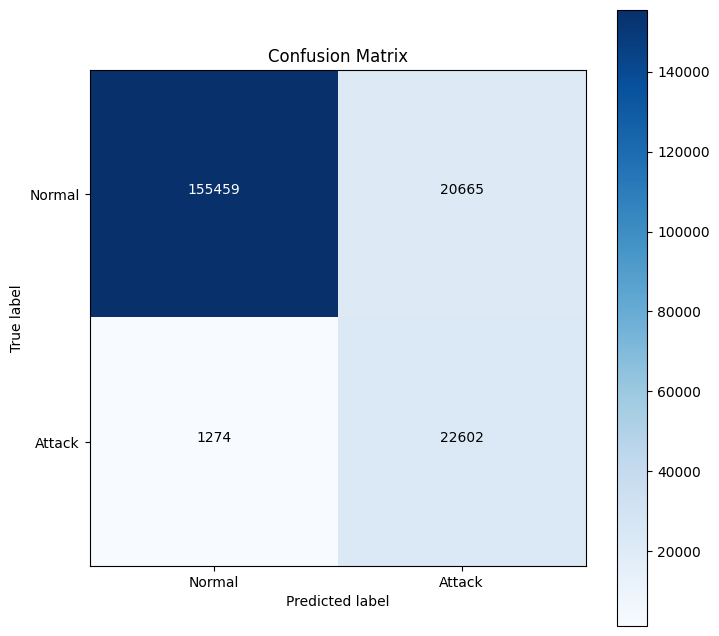

Accuracy: 0.8903 (Baseline: 0.7418, % Diff: 20.03)
Precision: 0.5224 (Baseline: 0.3100, % Diff: 68.52)
Recall: 0.9466 (Baseline: 0.9488, % Diff: -0.23)
F1: 0.6732 (Baseline: 0.4673, % Diff: 44.07)
Miss Rate: 0.0534 (Baseline: 0.0512, % Diff: 4.26)


In [23]:
model = build_NB()

part = partitions[8]

hist = model.fit(part[0], part[1])

LOCAL_PARAMS = [model.theta_,model.sigma_]
print(LOCAL_PARAMS)

cm, metrics = eval_model_others(model, cicids_test.X, cicids_test.y)
plot_cm(cm)

# print model metrics against the baseline
print(f"Accuracy: {metrics['accuracy']:.4f} (Baseline: {bl_acc:.4f}, % Diff: {100 * (metrics['accuracy'] - bl_acc) / bl_acc:.2f})")
print(f"Precision: {metrics['precision']:.4f} (Baseline: {bl_prec:.4f}, % Diff: {100 * (metrics['precision'] - bl_prec) / bl_prec:.2f})")
print(f"Recall: {metrics['recall']:.4f} (Baseline: {bl_rec:.4f}, % Diff: {100 * (metrics['recall'] - bl_rec) / bl_rec:.2f})")
print(f"F1: {metrics['f1']:.4f} (Baseline: {bl_f1:.4f}, % Diff: {100 * (metrics['f1'] - bl_f1) / bl_f1:.2f})")
print(f"Miss Rate: {metrics['miss_rate']:.4f} (Baseline: {bl_miss:.4f}, % Diff: {100 * (metrics['miss_rate'] - bl_miss) / bl_miss:.2f})")


In [24]:
inferences = hist.predict(cicids_test.X)

y_pred = np.round(inferences)

# remember: part[3] contains a list of the removed classes
y_pred_lack = y_pred[m_test.isin(part[3])]

print(f"Percentage of removed attacks detected (Local): {100 * len(y_pred_lack[y_pred_lack == 1]) / len(y_pred_lack):.2f}%")
print(hist.get_params())
# try with the baseline model
hist.set_params(**bl_params)
print(hist.get_params())

inferences = hist.predict(cicids_test.X)

y_pred = np.round(inferences)
y_pred_lack = y_pred[m_test.isin(part[3])]
print(f"Percentage of removed attacks detected (Baseline): {100 * len(y_pred_lack[y_pred_lack == 1]) / len(y_pred_lack):.2f}%")

Percentage of removed attacks detected (Local): 58.59%
{'priors': None, 'var_smoothing': 1e-09}
{'priors': None, 'var_smoothing': 1e-09}
Percentage of removed attacks detected (Baseline): 58.59%
